In [2]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
from src.model import convolution_pooling_op, fully_connected_op

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

# Data Generation

In [16]:
def generate_dataset(num_images: int, size: int = 4, noise: float = 0.2):
    """Generate a vertical horizontal left diagonal or right diagonal line on the grid and then add noise in to it"""
    images = []
    labels = []
    
    for i in range(num_images):
        # Create a blank image
        image = np.zeros((size, size), dtype=np.uint16)
        # Randomly choose a line orientation
        if np.random.rand() < 0.25:
            # Vertical line
            x = np.random.randint(0, size)
            image[:, x] = 255
            labels.append(0)  # Label for vertical line
        elif np.random.rand() < 0.5:
            # Horizontal line
            y = np.random.randint(0, size)
            image[y, :] = 255
            labels.append(1)
        elif np.random.rand() < 0.75:
            # Left diagonal line
            for j in range(size):
                image[j, j] = 255
            labels.append(2)
        else:
            # Right diagonal line
            for j in range(size):
                image[j, size - j - 1] = 255
            labels.append(3)
        
        # Add noise to the image
        noise_matrix = np.random.normal(0, noise * 255, (size, size))
        image = np.clip(image + noise_matrix, 0.0, 255.0)
        images.append(image.astype(np.float32) / 255.0)
    
    return np.array(images), np.array(labels)

In [20]:
images, labels = generate_dataset(100, noise=0.1)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)

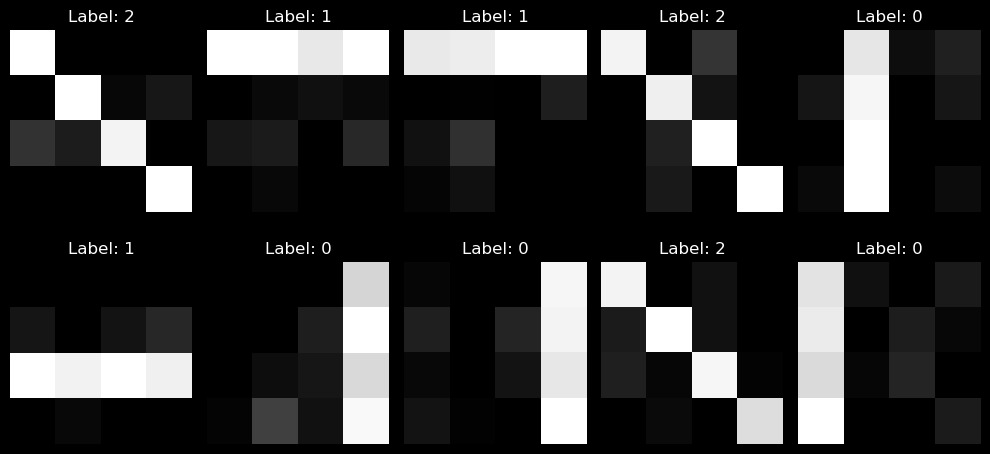

In [21]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i].reshape(train_images.shape[1], train_images.shape[2]), cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Creating Circuit

In [22]:
assert train_images.shape[1] == train_images.shape[2], "Images must be square"
N = train_images.shape[1]
B = 4
dev = qml.device("default.qubit", wires=N * N + B)
wire_arr = np.arange(N * N).reshape(N, N)

KERNEL_SIZE = 2
KERNEL_LAYERS = 2
KER_PARAM_COUNT = KERNEL_SIZE * KERNEL_SIZE * KERNEL_LAYERS
STRIDE = 2

In [23]:
@qml.qnode(dev)
def circuit(phi: np.ndarray):
    # First Convolution Layer
    first_kernel = phi[:KER_PARAM_COUNT]  
    first_pooling = phi[KER_PARAM_COUNT:KER_PARAM_COUNT + (KERNEL_SIZE * KERNEL_SIZE)]
    first_kernel = first_kernel.reshape((KERNEL_LAYERS, KERNEL_SIZE * KERNEL_SIZE))
    
    convolution_pooling_op(first_kernel, first_pooling, wire_arr, STRIDE)
    reduced_wire_arr = wire_arr[1::2, 1::2]
    
    # Second Convolution Layer
    second_kernel = phi[KER_PARAM_COUNT + (KERNEL_SIZE * KERNEL_SIZE): 2 * KER_PARAM_COUNT + (KERNEL_SIZE * KERNEL_SIZE)]
    second_pooling = phi[2 * KER_PARAM_COUNT + (KERNEL_SIZE * KERNEL_SIZE): 2 * (KER_PARAM_COUNT + (KERNEL_SIZE * KERNEL_SIZE))]
    second_kernel = second_kernel.reshape((KERNEL_LAYERS, KERNEL_SIZE * KERNEL_SIZE))
    
    convolution_pooling_op(second_kernel, second_pooling, reduced_wire_arr, STRIDE)
    reduced_wire_arr = reduced_wire_arr[1::2, 1::2]
    
    # Fully Connected Layer
    weights = phi[2 * (KER_PARAM_COUNT + (KERNEL_SIZE * KERNEL_SIZE)):2 * (KER_PARAM_COUNT + (KERNEL_SIZE * KERNEL_SIZE)) + 3*4]
    weights = weights.reshape((3, 4))
    bias = phi[2 * (KER_PARAM_COUNT + (KERNEL_SIZE * KERNEL_SIZE)) + 3*4:]
    
    fully_connected_op(weights, bias, reduced_wire_arr.flatten(), list(range(N*N, N*N + B)))
    
    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in reduced_wire_arr.flatten()]